# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [2]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

In [3]:
def thres(inputs, t, hard=True, old=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))
    else:
        if old:
            out = inputs * (torch.abs(inputs) > t)
        else:
            # out = torch.sign(inputs) * torch.max(\
            #                                     torch.abs(inputs) - torch.nan_to_num(torch.div(torch.pow(t, 6), torch.pow(torch.abs(inputs), 5))) \
            #                                     , torch.zeros(inputs.shape))
            # out = torch.sign(inputs) * torch.max(torch.abs(inputs) \
            #                                     - torch.div(t, torch.exp(3 * torch.div(torch.abs(inputs) - t, t))) \
            #                                     , torch.zeros(inputs.shape))
            # out = inputs * torch.max(1 - torch.div(torch.pow(t, 2), torch.pow(inputs, 2)), torch.zeros(inputs.shape))
            # out = torch.div(1,  1 + torch.exp(-100 * (torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))))) \
            #         + torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape)) \
            #         - t
            # mu = 1.0005 * t
            # out = inputs * (torch.abs(inputs) >= mu) \
            #         + torch.sign(inputs) * (mu/(mu-t))*(torch.abs(inputs) - t) * (mu > torch.abs(inputs)) * (torch.abs(inputs) >= t)
            gamma, beta = 0.95, 1
            out = inputs * (torch.abs(inputs) > torch.sqrt(gamma * beta * t**2)) * (beta <= gamma) \
                    + torch.sign(inputs) * torch.min(beta/(beta - gamma) * torch.max(torch.abs(inputs) - (t * gamma), torch.zeros(inputs.shape)), torch.abs(inputs)) * (beta > gamma)
    return out

In [4]:
def AccAltProj(M0, r, tol, gamma, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    beta = 1/(2 * np.power(m * n, 1/4))
    beta_init = 4 * beta
    zeta = beta_init * torch.linalg.norm(M0, 2)
    S = thres(M0, zeta)#, False)
    U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
    ## NOTE: torch.linalg.svd(M) returns U, S, V such that M=USV not USV.T
    U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
    L = U @ torch.diag(Sigma) @ V.t()
    zeta = beta * Sigma[0]
    S = thres(M0 - L, zeta)#, False)
    ## Initial loss
    err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
    loss.append(err)
    for t in range(max_iter):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sigma, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sigma[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sigma[r] + torch.pow(gamma, t + 1) * Sigma[0])
        S = thres(M0 - L, zeta)#, False)
        ## Compute error
        err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        loss.append(err)
        if err < tol:
            return loss, L, S
    return loss, L, S



## returns: loss, L, S
def IRCUR(M0, r, tol, gamma, con, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
    zeta = torch.max(torch.abs(M0))
    C, pinv_U, R = torch.zeros(M0.shape), torch.zeros([M0.shape[1], M0.shape[0]]), torch.zeros(M0.shape)
    for t in range(max_iter):
        ## resample rows and columns
        rows, cols = resample(m, n, siz_row, siz_col)
        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        ## compute submatrices of L from previous iteration
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        ## update S using submatrices of L
        S_rows = thres(M0_rows - L_rows, zeta)
        S_cols = thres(M0_cols - L_cols, zeta)
        ## update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        ## calculate Moore-Penrose inverse of Sigma
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        ## update zeta
        zeta = gamma * zeta
        ## update loss
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        loss.append(err)
        if err < tol:
            L = C @ pinv_U @ R
            S = thres(M0 - L, zeta)
            return loss, L, S
    L = C @ pinv_U @ R
    S = thres(M0 - L, zeta)
    return loss, L, S

## Unrolled version

In [5]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, d1, d2):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(1/(2 * np.power(d1 * d2, 1/4))))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.579e-01; beta=7.070e-02

***results: only relative err increased (from 0 to <5e-07 which is also very good) whereas the other errors got reduced***

In [6]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 50              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [119]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))

In [120]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=7e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

[Parameter containing:
tensor(7.017e-01, requires_grad=True), Parameter containing:
tensor(3.242e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.478e-10) tensor(-1.148e-10, dtype=torch.float64)
Epoch 1/8 at cost=7.374221372424827e-11
[Parameter containing:
tensor(7.130e-01, requires_grad=True), Parameter containing:
tensor(4.038e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.646e-09) tensor(-2.429e-09, dtype=torch.float64)
Epoch 1/8 at cost=7.43379108270048e-11
[Parameter containing:
tensor(7.254e-01, requires_grad=True), Parameter containing:
tensor(4.764e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.526e-09) tensor(-9.585e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.184547321342322e-10
[Parameter containing:
tensor(7.351e-01, requires_grad=True), Parameter containing:
tensor(5.311e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.202e-10) tensor(-1.223e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.3600116692547015e-11
[Parameter containing:
tenso

#### Evaluating unrolled network on train dataset

In [121]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


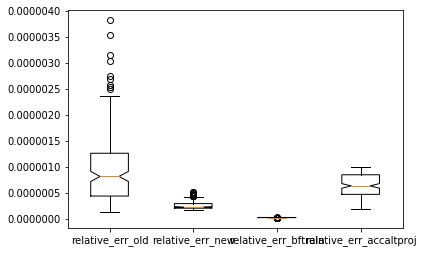

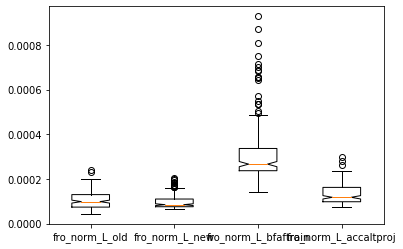

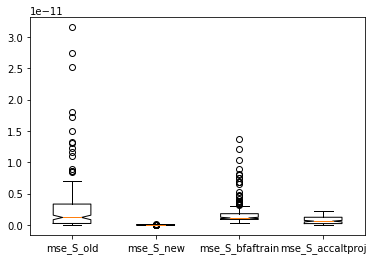

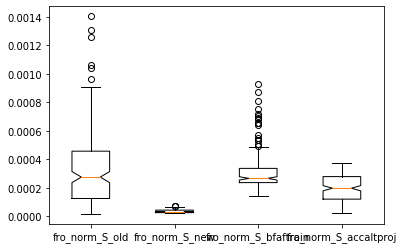

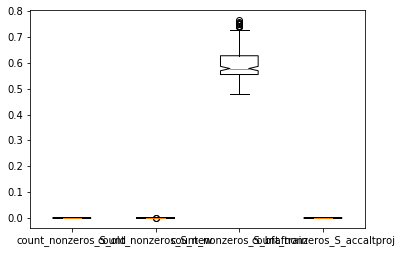

In [122]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [123]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.3045321345275995e-29
fro_norm_L_new, fro_norm_L_old:  0.03667385880396659
mse_S_new, mse_S_old:  1.1174283170965377e-13
fro_norm_S_new, fro_norm_S_old:  6.17776753051694e-33
count_nonzeros_S_new, count_nonzeros_S_old:  7.192315325970338e-47

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  7.182014890334917e-53
fro_norm_L_new, fro_norm_L_accaltproj:  3.733806593487735e-17
mse_S_new, mse_S_accaltproj:  1.0078348332832505e-37
fro_norm_S_new, fro_norm_S_accaltproj:  2.314816620635743e-53
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  2.3864017476716142e-48

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.3238649857459426e-49
mse_S_new, mse_S_bftrain:  3.4113579390258314e-25
fro_norm_S_new, fro_norm_S_bftrain:  2.4717269839622807e-65
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.8088553392016664e-179


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


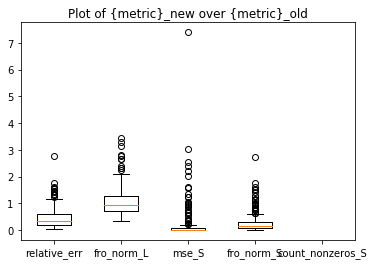

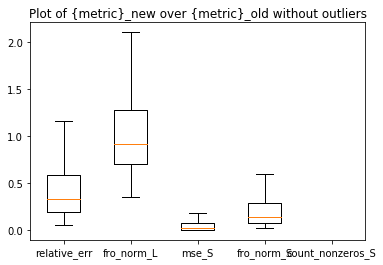

relative_err: 12/180 outliers
fro_norm_L: 11/180 outliers
mse_S: 30/180 outliers
fro_norm_S: 25/180 outliers
count_nonzeros_S: 0/180 outliers


In [124]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [125]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0600364306635654e-42
fro_norm_L:  0.9490010013281129
mse_S:  2.592058071929932e-31
fro_norm_S:  4.251253777063609e-59
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


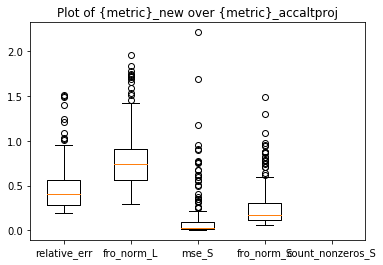

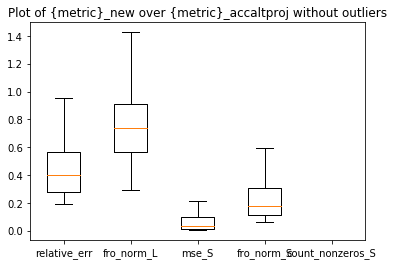

relative_err: 10/180 outliers
fro_norm_L: 13/180 outliers
mse_S: 29/180 outliers
fro_norm_S: 21/180 outliers
count_nonzeros_S: 0/180 outliers


In [126]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [127]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.013752099038056e-65
fro_norm_L:  6.747640399230733e-14
mse_S:  8.417938768150798e-91
fro_norm_S:  8.711771336035677e-88
count_nonzeros_S:  nan


In [128]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 5.2444443e-06
3.2e-05 2.96e-05


#### Evaluating unrolled network on test dataset

In [129]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


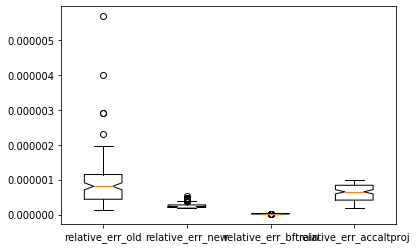

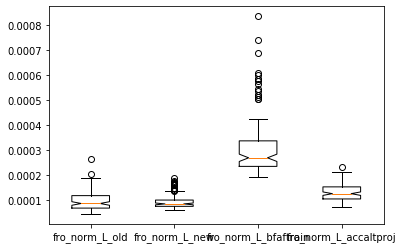

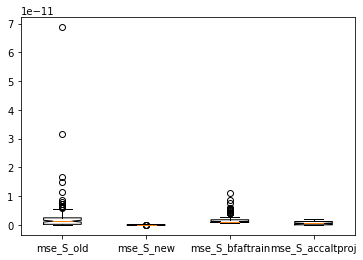

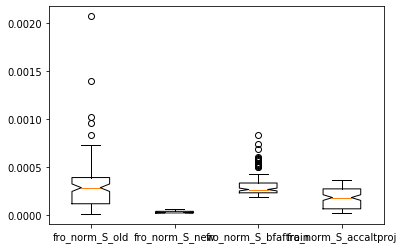

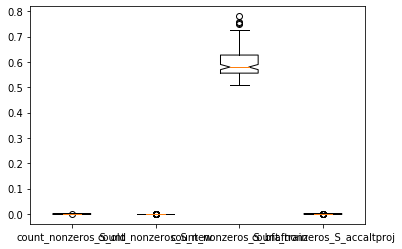

In [130]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [131]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.7715138883136574e-17
fro_norm_L_new, fro_norm_L_old:  0.552254532928856
mse_S_new, mse_S_old:  9.41569530048597e-06
fro_norm_S_new, fro_norm_S_old:  1.0563448462247925e-19
count_nonzeros_S_new, count_nonzeros_S_old:  9.720055498086535e-27

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  5.2557668946730994e-33
fro_norm_L_new, fro_norm_L_accaltproj:  1.350833418865009e-14
mse_S_new, mse_S_accaltproj:  7.344589131035352e-23
fro_norm_S_new, fro_norm_S_accaltproj:  4.923429575666746e-30
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  7.110427658818149e-25

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  3.508462148892859e-38
mse_S_new, mse_S_bftrain:  5.065987085698776e-21
fro_norm_S_new, fro_norm_S_bftrain:  7.527612788463888e-49
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.9829945799497826e-121


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/3102520907.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


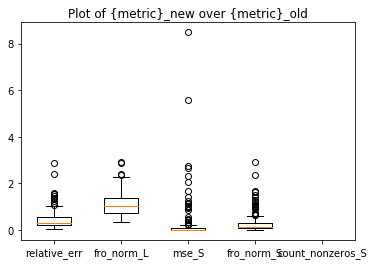

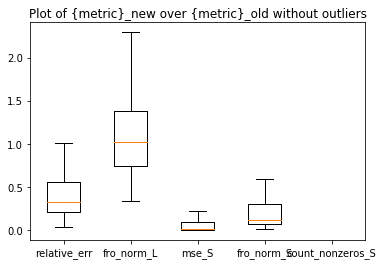

relative_err: 11/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 24/120 outliers
fro_norm_S: 21/120 outliers
count_nonzeros_S: 0/120 outliers


In [132]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [133]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  2.986236258221441e-24
fro_norm_L:  0.997839137490733
mse_S:  1.0668526860547295e-10
fro_norm_S:  5.784417225062791e-30
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/3730118138.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


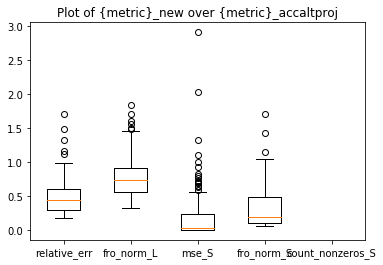

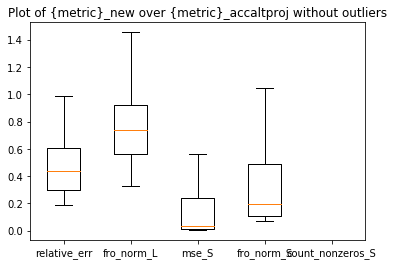

relative_err: 5/120 outliers
fro_norm_L: 6/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 3/120 outliers
count_nonzeros_S: 0/120 outliers


In [134]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [135]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.2421076841042095e-40
fro_norm_L:  5.829176662018734e-13
mse_S:  4.5792325209586757e-42
fro_norm_S:  5.291709499273532e-45
count_nonzeros_S:  nan


In [137]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))

0.0 4.5333336e-06 4.8e-05
1.6e-05 2.4133335e-05 6.4e-05


### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.433e-01,; beta=5.649e-02

In [24]:
## ======================== 0. set constants ========================
#d1 = 250                   # num. of rows
#d2 = 250                   # num. of columns
#max_iter = 100              # num. of layers trained
alpha_true = 0.3
c_true = 1
#r = 2
#dataset_size = 300

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [25]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est2.append((L0, S0, M_true))

In [138]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=7e-03, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est2)

[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.165e-02, dtype=torch.float64, requires_grad=True)]
tensor(-7.481e-11) tensor(-3.787e-11, dtype=torch.float64)
Epoch 1/8 at cost=2.1972477656784228e-11
[Parameter containing:
tensor(7.004e-01, requires_grad=True), Parameter containing:
tensor(3.180e-02, dtype=torch.float64, requires_grad=True)]
tensor(-8.204e-10) tensor(-3.991e-10, dtype=torch.float64)
Epoch 1/8 at cost=4.0224275299483025e-11
[Parameter containing:
tensor(7.007e-01, requires_grad=True), Parameter containing:
tensor(3.199e-02, dtype=torch.float64, requires_grad=True)]
tensor(-7.085e-10) tensor(-3.521e-10, dtype=torch.float64)
Epoch 1/8 at cost=3.038062856841606e-11
[Parameter containing:
tensor(7.010e-01, requires_grad=True), Parameter containing:
tensor(3.214e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.046e-10) tensor(-6.941e-11, dtype=torch.float64)
Epoch 1/8 at cost=1.7415936748310656e-11
[Parameter containing:
te

#### Evaluating unrolled network on train dataset

In [139]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


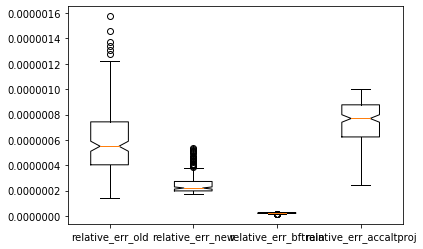

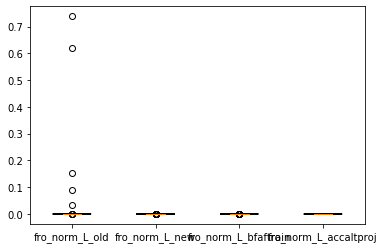

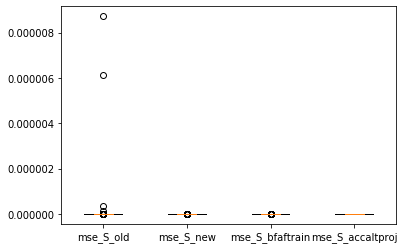

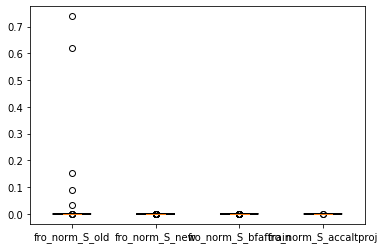

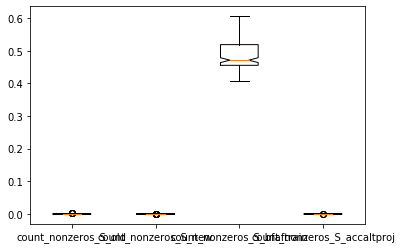

In [140]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [141]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  1.1532904104699617e-50
fro_norm_L_new, fro_norm_L_old:  1.5582859548802297e-08
mse_S_new, mse_S_old:  5.1167653373960317e-26
fro_norm_S_new, fro_norm_S_old:  5.1170486842349636e-26
count_nonzeros_S_new, count_nonzeros_S_old:  nan

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.5234139940323e-85
fro_norm_L_new, fro_norm_L_accaltproj:  1.4399556882150524e-33
mse_S_new, mse_S_accaltproj:  1.9512477444197625e-95
fro_norm_S_new, fro_norm_S_accaltproj:  1.951194092841768e-95
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  nan

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.17575844643045e-86
mse_S_new, mse_S_bftrain:  2.1449207870219516e-113
fro_norm_S_new, fro_norm_S_bftrain:  2.1446316404269612e-113
count_nonzeros_S_new, count_nonzeros_S_bftrain:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2360404741.py:27: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7148: RuntimeWarning: invalid value encountered in subtract
  d = (a - b).astype(np.float64)
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2360404741.py:34: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2360404741.py:40: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest

/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


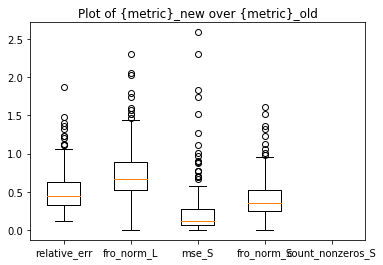

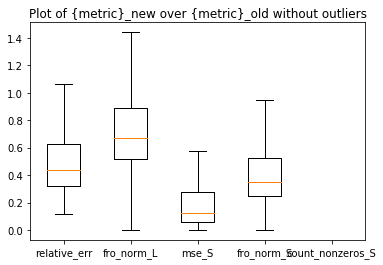

relative_err: 11/180 outliers
fro_norm_L: 10/180 outliers
mse_S: 19/180 outliers
fro_norm_S: 9/180 outliers
count_nonzeros_S: 0/180 outliers


In [142]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [143]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  6.64062234087967e-55
fro_norm_L:  4.517993023522323e-16
mse_S:  1.830772393409045e-63
fro_norm_S:  3.011294223593633e-67
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


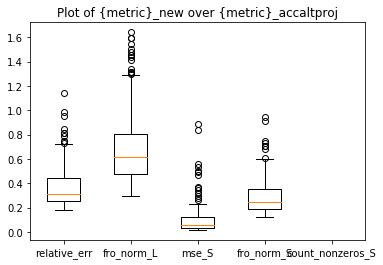

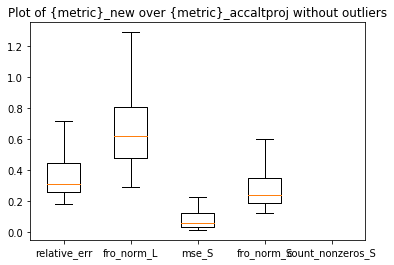

relative_err: 10/180 outliers
fro_norm_L: 15/180 outliers
mse_S: 14/180 outliers
fro_norm_S: 8/180 outliers
count_nonzeros_S: 0/180 outliers


In [144]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [145]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.023081173624699e-106
fro_norm_L:  2.944308115562993e-28
mse_S:  1.2586236136924157e-154
fro_norm_S:  1.1397876691038662e-127
count_nonzeros_S:  nan


In [147]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

1.6e-05 1.3333334e-05 6.4e-05
6.4e-05 6.088889e-05 0.000144
4.8e-05 0.00012764444 0.002944


#### Evaluating unrolled network on test dataset

In [148]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


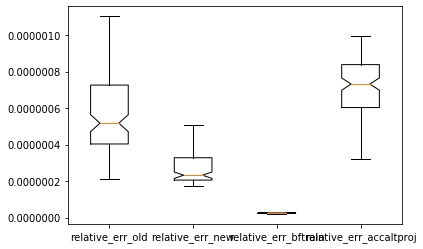

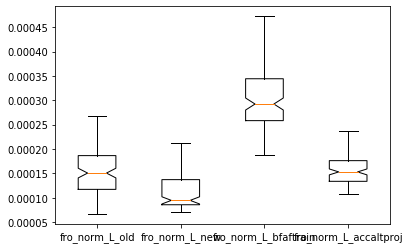

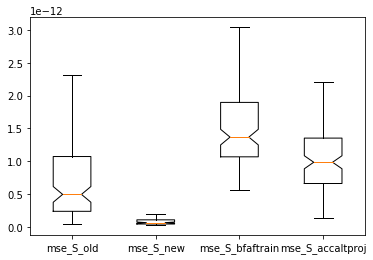

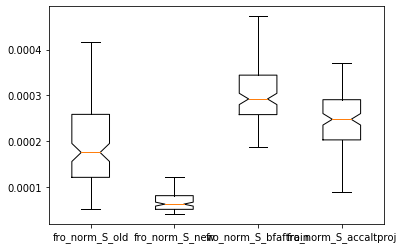

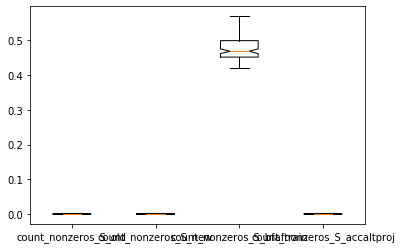

In [149]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [150]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  3.139155649576208e-25
fro_norm_L_new, fro_norm_L_old:  0.02353100104112257
mse_S_new, mse_S_old:  0.06974796441293656
fro_norm_S_new, fro_norm_S_old:  0.023382380402424845
count_nonzeros_S_new, count_nonzeros_S_old:  0.0005400215209348978

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  2.328039999275116e-51
fro_norm_L_new, fro_norm_L_accaltproj:  1.0801733006532677e-17
mse_S_new, mse_S_accaltproj:  1.2173695587094345e-42
fro_norm_S_new, fro_norm_S_accaltproj:  1.6842623513476184e-55
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  2.6659296937880377e-46

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.901502675966444e-32
mse_S_new, mse_S_bftrain:  1.0961059115965054e-16
fro_norm_S_new, fro_norm_S_bftrain:  8.263770240747033e-41
count_nonzeros_S_new, count_nonzeros_S_bftrain:  3.386929307347482e-129


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


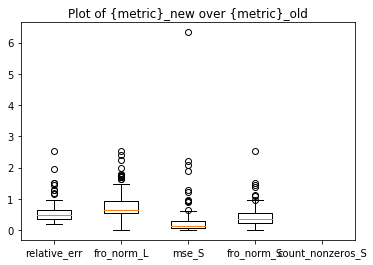

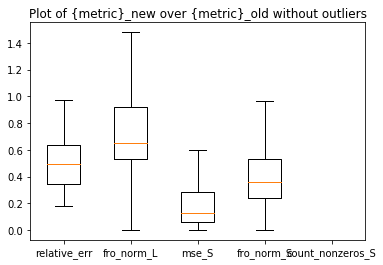

relative_err: 9/120 outliers
fro_norm_L: 12/120 outliers
mse_S: 11/120 outliers
fro_norm_S: 7/120 outliers
count_nonzeros_S: 0/120 outliers


In [151]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [152]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  8.4568097608936e-27
fro_norm_L:  1.1715909281390202e-06
mse_S:  7.441214911321548e-21
fro_norm_S:  3.649061000965725e-36
count_nonzeros_S:  nan


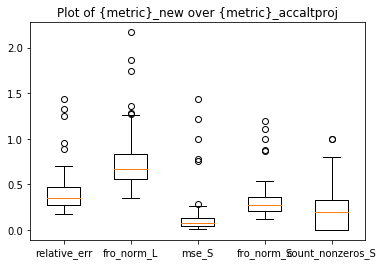

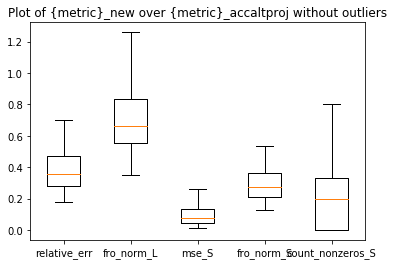

relative_err: 5/120 outliers
fro_norm_L: 6/120 outliers
mse_S: 6/120 outliers
fro_norm_S: 5/120 outliers
count_nonzeros_S: 2/120 outliers


In [153]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [154]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.3436773556969833e-60
fro_norm_L:  4.4028226398430876e-16
mse_S:  3.532607882202473e-78
fro_norm_S:  1.802329809326574e-74
count_nonzeros_S:  4.246607275033571e-68


In [155]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

1.6e-05 1.4400001e-05 6.4e-05
6.4e-05 6.0000002e-05 0.000144
4.8e-05 0.00019653332 0.002912


### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.195e-01; beta=1.112e-01

*** ***

In [79]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.01
c_true = 1
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [80]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est3.append((L0, S0, M_true))

In [218]:
1/(2 * np.power(250 * 250, 1/4))

0.03162277660168379

In [162]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-03, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est3)

[Parameter containing:
tensor(7.006e-01, requires_grad=True), Parameter containing:
tensor(3.200e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.649e-09) tensor(-2.351e-09, dtype=torch.float64)
Epoch 1/8 at cost=1.8432972481718934e-08
[Parameter containing:
tensor(7.018e-01, requires_grad=True), Parameter containing:
tensor(3.291e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.192e-08) tensor(-1.662e-08, dtype=torch.float64)
Epoch 1/8 at cost=3.4691402528430615e-10
[Parameter containing:
tensor(7.030e-01, requires_grad=True), Parameter containing:
tensor(3.383e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.123e-08) tensor(-9.506e-09, dtype=torch.float64)
Epoch 1/8 at cost=1.211081013252624e-09
[Parameter containing:
tensor(7.040e-01, requires_grad=True), Parameter containing:
tensor(3.454e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.007e-09) tensor(-4.371e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.1777073538610239e-08
[Parameter containing:
te

#### Evaluating unrolled network on train dataset

In [163]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


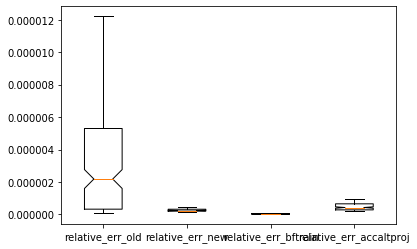

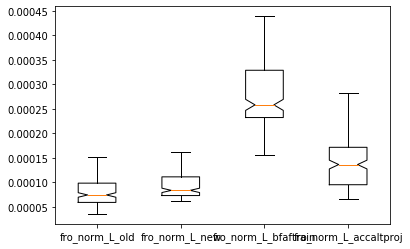

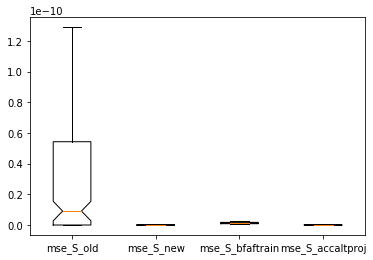

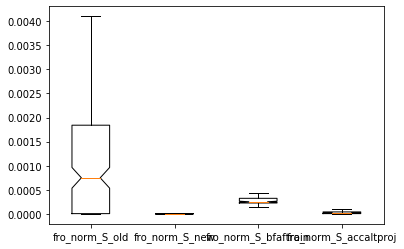

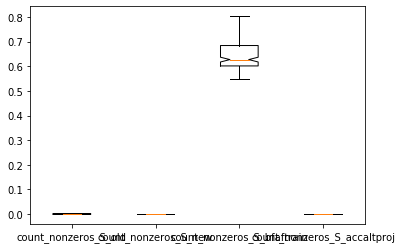

In [164]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [165]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  6.559089119779721e-17
fro_norm_L_new, fro_norm_L_old:  0.9994114061246642
mse_S_new, mse_S_old:  2.399054884843929e-06
fro_norm_S_new, fro_norm_S_old:  1.6153117956347862e-17
count_nonzeros_S_new, count_nonzeros_S_old:  2.390758124913258e-32

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  8.042545913204077e-27
fro_norm_L_new, fro_norm_L_accaltproj:  9.044108754730392e-21
mse_S_new, mse_S_accaltproj:  1.8366283428967268e-08
fro_norm_S_new, fro_norm_S_accaltproj:  4.983392022764173e-13
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  8.528939427616128e-10

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.444219023948675e-51
mse_S_new, mse_S_bftrain:  8.670292439839795e-26
fro_norm_S_new, fro_norm_S_bftrain:  6.303017468666525e-70
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.708621814182311e-175


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


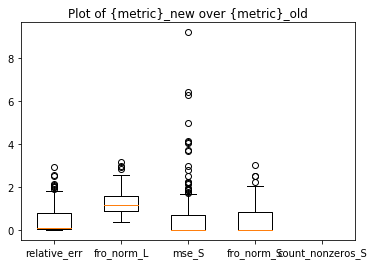

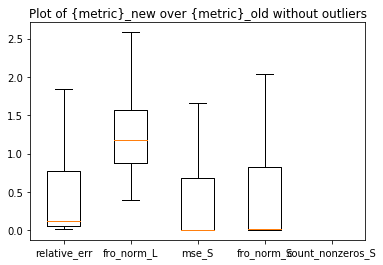

relative_err: 9/180 outliers
fro_norm_L: 4/180 outliers
mse_S: 22/180 outliers
fro_norm_S: 4/180 outliers
count_nonzeros_S: 0/180 outliers


In [166]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [167]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  2.68449764667248e-23
fro_norm_L:  0.999999999853699
mse_S:  1.1917107132213976e-05
fro_norm_S:  2.1535859572592223e-26
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


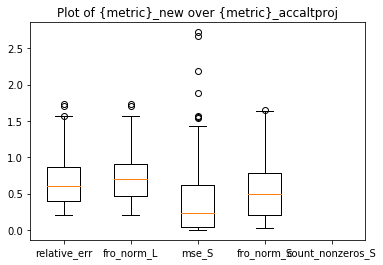

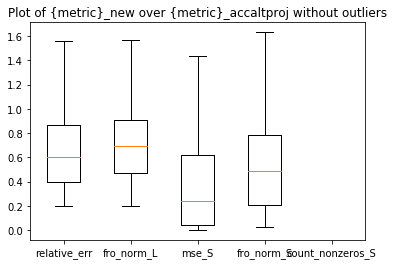

relative_err: 3/180 outliers
fro_norm_L: 2/180 outliers
mse_S: 7/180 outliers
fro_norm_S: 1/180 outliers
count_nonzeros_S: 0/180 outliers


In [168]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [169]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.2123296706440695e-27
fro_norm_L:  2.1799247103752443e-20
mse_S:  6.399915430258021e-35
fro_norm_S:  1.011857804581503e-38
count_nonzeros_S:  nan


In [170]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 7.9999995e-07 1.6e-05
0.0 3.911111e-06 3.2e-05
1.6e-05 2.1155556e-05 8e-05


#### Evaluating unrolled network on test dataset

In [171]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


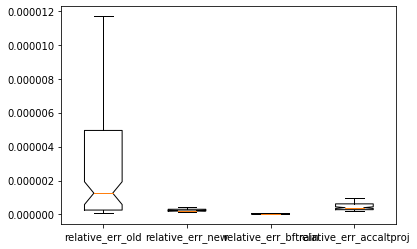

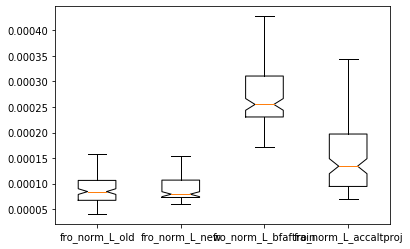

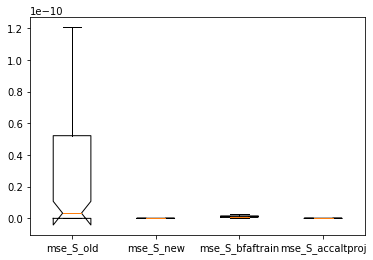

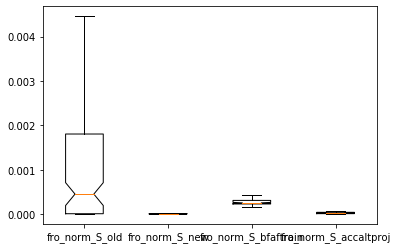

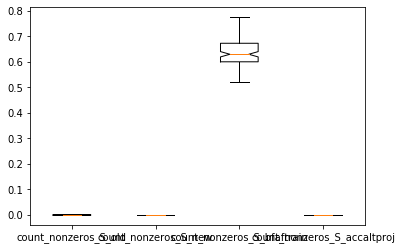

In [172]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [173]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  2.1274005261846353e-08
fro_norm_L_new, fro_norm_L_old:  0.8619426980260989
mse_S_new, mse_S_old:  0.020268141779057364
fro_norm_S_new, fro_norm_S_old:  4.299616315186887e-09
count_nonzeros_S_new, count_nonzeros_S_old:  2.448678209457295e-17

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0560786371492528e-17
fro_norm_L_new, fro_norm_L_accaltproj:  4.245599752729798e-16
mse_S_new, mse_S_accaltproj:  0.00015912995178441846
fro_norm_S_new, fro_norm_S_accaltproj:  1.0395831445600261e-07
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  3.475107998788179e-05

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.3513058921330455e-40
mse_S_new, mse_S_bftrain:  1.1364232395335338e-21
fro_norm_S_new, fro_norm_S_bftrain:  3.6486811907623367e-53
count_nonzeros_S_new, count_nonzeros_S_bftrain:  5.243294767305632e-121


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


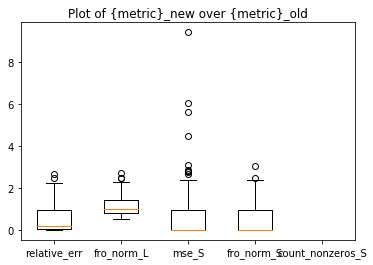

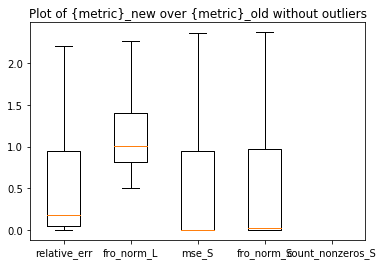

relative_err: 2/120 outliers
fro_norm_L: 3/120 outliers
mse_S: 9/120 outliers
fro_norm_S: 2/120 outliers
count_nonzeros_S: 0/120 outliers


In [174]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [175]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.7573353978222205e-12
fro_norm_L:  0.9993022265191092
mse_S:  0.006325627833774059
fro_norm_S:  6.868686464041275e-14
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


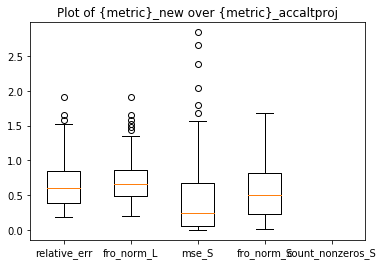

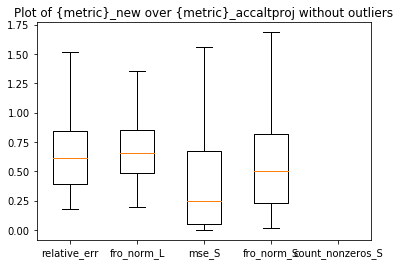

relative_err: 3/120 outliers
fro_norm_L: 6/120 outliers
mse_S: 6/120 outliers
fro_norm_S: 0/120 outliers
count_nonzeros_S: 0/120 outliers


In [176]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [177]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  5.823610288219253e-19
fro_norm_L:  3.617524149034986e-17
mse_S:  7.43625533844258e-20
fro_norm_S:  1.7351296696443784e-24
count_nonzeros_S:  nan


In [178]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 1.0666666e-06 3.2e-05
0.0 3.0666667e-06 3.2e-05
1.6e-05 1.7066668e-05 8e-05


### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=7.359e-01; beta=4.489e-02

*** ***

In [97]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.1
c_true = 10
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [98]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est4.append((L0, S0, M_true))

In [198]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-01, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est4)

[Parameter containing:
tensor(7.007e-01, requires_grad=True), Parameter containing:
tensor(3.199e-02, dtype=torch.float64, requires_grad=True)]
tensor(-3.561e-11) tensor(-1.851e-11, dtype=torch.float64)
Epoch 1/8 at cost=4.051808541460922e-11
[Parameter containing:
tensor(7.021e-01, requires_grad=True), Parameter containing:
tensor(3.269e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.043e-10) tensor(-5.035e-11, dtype=torch.float64)
Epoch 1/8 at cost=7.563731758974956e-12
[Parameter containing:
tensor(7.034e-01, requires_grad=True), Parameter containing:
tensor(3.330e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.743e-11) tensor(-2.223e-11, dtype=torch.float64)
Epoch 1/8 at cost=7.493566531180385e-12
[Parameter containing:
tensor(7.078e-01, requires_grad=True), Parameter containing:
tensor(3.549e-02, dtype=torch.float64, requires_grad=True)]
tensor(-6.346e-10) tensor(-3.087e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.3037632605461535e-11
[Parameter containing:
tens

#### Evaluating unrolled network on train dataset

In [180]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


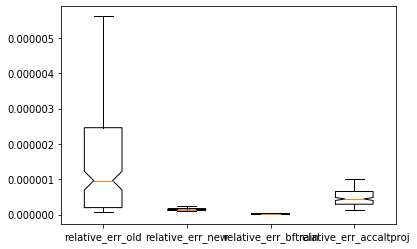

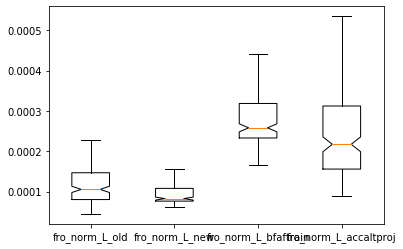

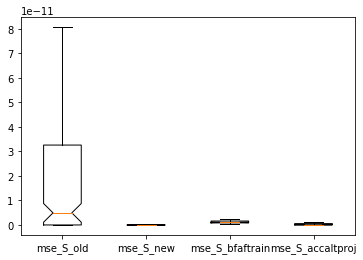

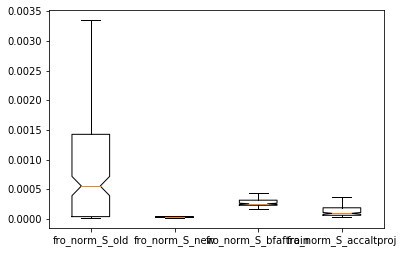

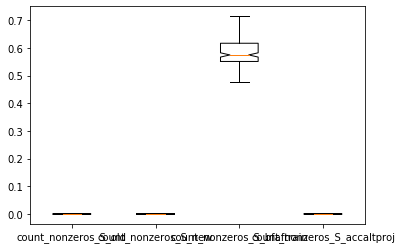

In [181]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [199]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.159658372851787e-14
fro_norm_L_new, fro_norm_L_old:  0.004016282411196734
mse_S_new, mse_S_old:  5.37706942422456e-07
fro_norm_S_new, fro_norm_S_old:  8.482811918146755e-15
count_nonzeros_S_new, count_nonzeros_S_old:  0.9999999966039328

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  3.250031155782045e-30
fro_norm_L_new, fro_norm_L_accaltproj:  4.1522986867270055e-23
mse_S_new, mse_S_accaltproj:  1.5107300136007257e-09
fro_norm_S_new, fro_norm_S_accaltproj:  2.749717991619777e-16
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  0.9999999984378337

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  8.295514495846353e-35
mse_S_new, mse_S_bftrain:  1.0862202857707863e-16
fro_norm_S_new, fro_norm_S_bftrain:  5.037031031605137e-44
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0086527751392034e-123


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


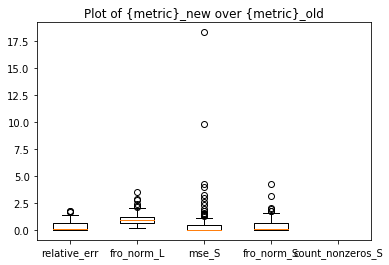

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


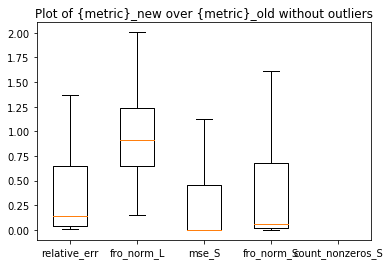

relative_err: 3/120 outliers
fro_norm_L: 6/120 outliers
mse_S: 18/120 outliers
fro_norm_S: 6/120 outliers
count_nonzeros_S: 0/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [200]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [201]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  2.0418254612197056e-29
fro_norm_L:  0.647243778522453
mse_S:  0.020811127191885957
fro_norm_S:  1.18061254209597e-16
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


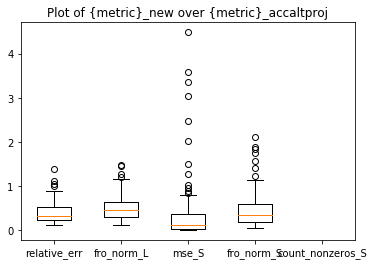

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


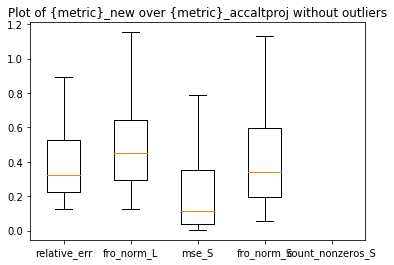

relative_err: 4/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 12/120 outliers
fro_norm_S: 7/120 outliers
count_nonzeros_S: 0/120 outliers


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [202]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [203]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  4.56642453154426e-54
fro_norm_L:  2.792217706972972e-38
mse_S:  1.1446117476289494e-16
fro_norm_S:  6.136132273239063e-29
count_nonzeros_S:  nan


In [204]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.000128 0.0005784 0.005024
0.0 5.4666666e-06 4.8e-05
1.6e-05 1.9600002e-05 6.4e-05


#### Evaluating unrolled network on test dataset

In [205]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


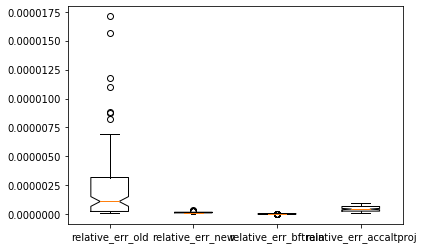

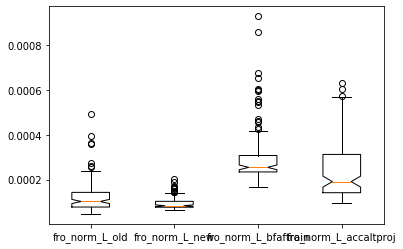

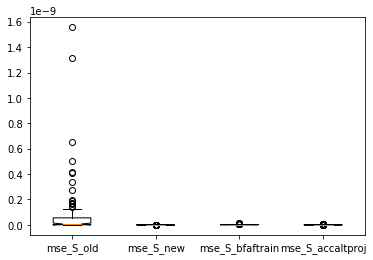

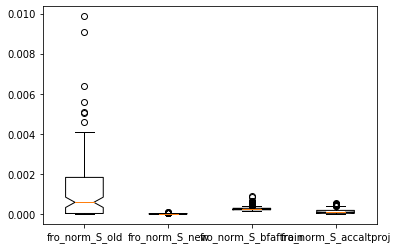

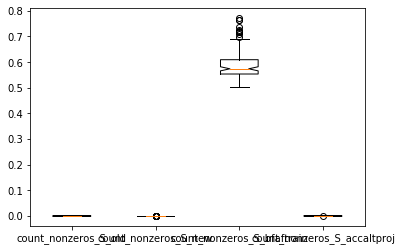

In [206]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [207]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.245684245124085e-12
fro_norm_L_new, fro_norm_L_old:  1.9103453623402072e-05
mse_S_new, mse_S_old:  9.266371257935711e-05
fro_norm_S_new, fro_norm_S_old:  2.374321231518678e-12
count_nonzeros_S_new, count_nonzeros_S_old:  0.8842316379368482

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  3.173370652455835e-29
fro_norm_L_new, fro_norm_L_accaltproj:  6.604578527122348e-23
mse_S_new, mse_S_accaltproj:  1.1190974406726196e-09
fro_norm_S_new, fro_norm_S_accaltproj:  6.010098835546886e-17
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  0.9815020369299345

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  6.481843415537724e-35
mse_S_new, mse_S_bftrain:  7.680854188553864e-17
fro_norm_S_new, fro_norm_S_bftrain:  2.0924719470889573e-45
count_nonzeros_S_new, count_nonzeros_S_bftrain:  8.576250766061587e-124


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2174885101.py:5: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])


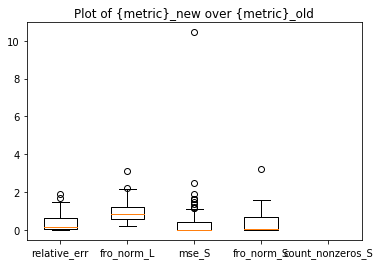

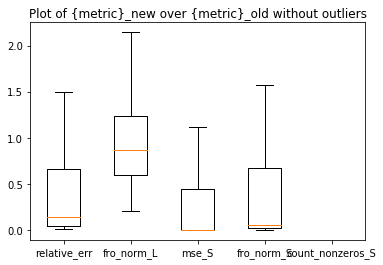

relative_err: 2/120 outliers
fro_norm_L: 2/120 outliers
mse_S: 11/120 outliers
fro_norm_S: 1/120 outliers
count_nonzeros_S: 0/120 outliers


In [208]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [209]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  6.648496910173569e-31
fro_norm_L:  0.13087574427045237
mse_S:  4.161704068729844e-10
fro_norm_S:  2.4693223554903504e-28
count_nonzeros_S:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: invalid value encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_61504/2948823882.py:5: RuntimeWarning: divide by zero encountered in true_divide
  count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])


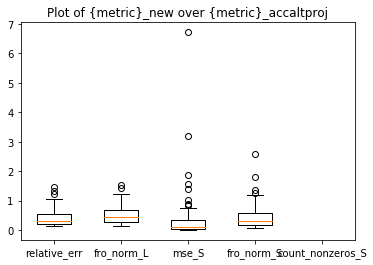

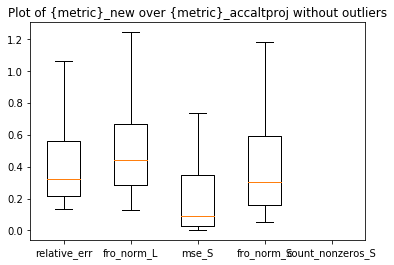

relative_err: 3/120 outliers
fro_norm_L: 2/120 outliers
mse_S: 9/120 outliers
fro_norm_S: 4/120 outliers
count_nonzeros_S: 0/120 outliers


In [210]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [211]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  5.881271640311224e-48
fro_norm_L:  3.5509471165109845e-38
mse_S:  8.719626413412173e-19
fro_norm_S:  1.9258435525798967e-34
count_nonzeros_S:  nan


In [212]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new), np.max(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj), np.max(count_nonzeros_S_accaltproj))
print(np.median(count_nonzeros_S_old), np.mean(count_nonzeros_S_old), np.max(count_nonzeros_S_old))

0.0 3.7066664e-05 0.001296
0.0 5.4666666e-06 4.8e-05
1.6e-05 1.88e-05 8e-05
